[1. Importing libraries](#section-one)

[2. Exploratory data analysis](#section-two)

[3. Preprocessing](#section-three)

[4. Wordcloud](#section-four)

[5. Journey from tokens to vector](#section-five)

[6. Text Classifcation models](#section-six)

[7. Submission](#section-seven)

<a id="section-one"></a>
# 1. Importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


Using TensorFlow backend.


In [2]:
### Reading train dataset ###

train = pd.read_csv('../input/nlp-getting-started/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
# Reading test data ###
test = pd.read_csv('../input/nlp-getting-started/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
test.shape

(3263, 4)

<a id="section-two"></a>
# 2. Exploratory data analysis

1. Check for missingness

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

The location column has a lot of missing values in both train and test sets. Keyword column has 61 and 26  missing values in train and test set respectively

2. Checking for duplicates

In [8]:
train.duplicated().sum()

0

2. Checkout Target column

In [9]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

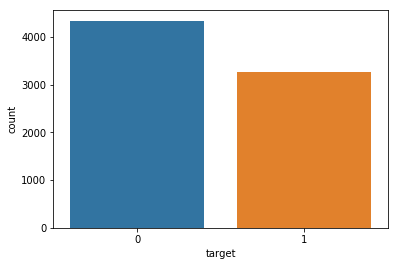

In [10]:
ax = sns.countplot(x="target", data = train)
plt.show()

3. Checkout text column

In [11]:
print("Example of a disaster tweet:\n")
dis_tw = train.loc[train.target == 1,['text']]
dis_tw.loc[0]

Example of a disaster tweet:



text    Our Deeds are the Reason of this #earthquake M...
Name: 0, dtype: object

In [12]:
print("Example of a normal tweet:\n")
norm_tw = train.loc[train.target == 0,['text']]
norm_tw.values[0]

Example of a normal tweet:



array(["What's up man?"], dtype=object)

4. Checkout location column

Text(0.5, 1.0, 'Top 30 locations in the train set')

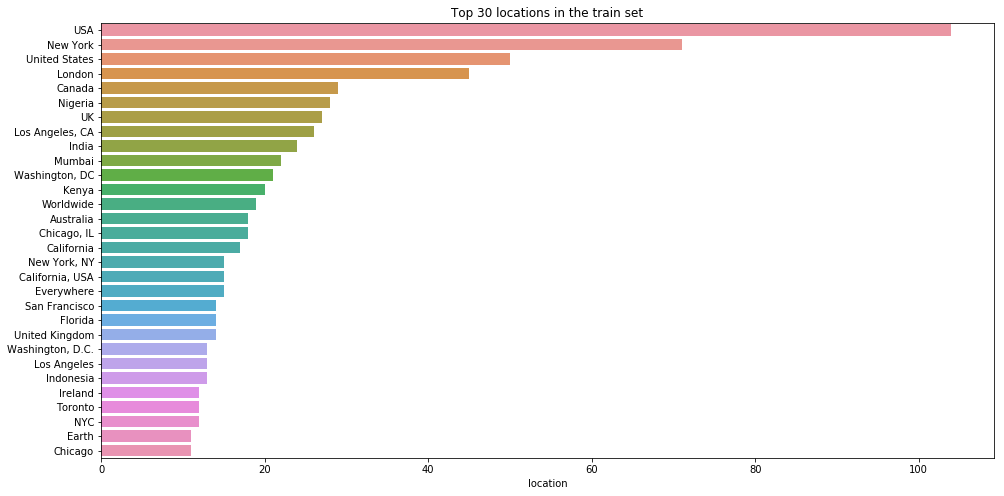

In [13]:
loca = train.location.value_counts(dropna = False)
fig = plt.figure(figsize = (16, 8))
sns.barplot(x= loca.iloc[0:31], y = loca.index[0:31], orient ='h')
plt.title("Top 30 locations in the train set")

Some locations e.g. New York, California, Clifornia, USA belong to same country. Cleaning the location column:

In [14]:
# country_code = {"New York" :"USA", "United States": "USA", "London":"UK", "Los Angeles, CA": "USA", "Mumbai": "India",
#                "Washington, DC":"USA", "Chicago":"USA", "Chicago, IL":'USA',"California":'USA',"California, USA":'USA',
#                             "FLorida":'USA',
#                             "Nigeria":'Africa',
#                             "Kenya":'Africa',
#                             "Everywhere":'Worldwide',"San Francisco":'USA',
#                             "United Kingdom":'UK',"Los Angeles":'USA',
#                             "Toronto":'Canada',"San Francisco, CA":'USA',
#                             "NYC":'USA',
#                              "Earth":'Worldwide',"Ireland":'UK',
#                              "New York, NY":'USA'}
# train.location = train.location.map(country_code)

In [15]:
loca = train.location.unique()
# sns.barplot(x= loca.values[0:4], y = loca.index[0:4], orient ='h')
# plt.title("Top 30 locations in the train set")
len(loca)

3342

5. Checkout keyword column

In [16]:
c = train.keyword.value_counts(dropna = False)
c

NaN                      61
fatalities               45
armageddon               42
deluge                   42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

Visualizing top 10 keywords in train set

Text(0.5, 1.0, 'Top 10 keywords in train set')

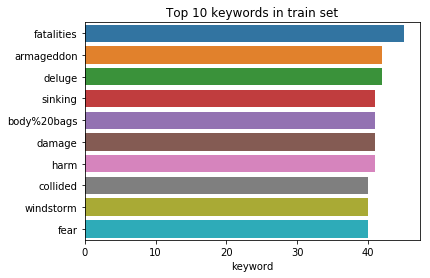

In [17]:
sns.barplot(y = c.index[0:11], x = c.iloc[0:11], orient = 'h')
plt.title("Top 10 keywords in train set")

Text(0.5, 1.0, 'Top 10 keywords in normal tweets')

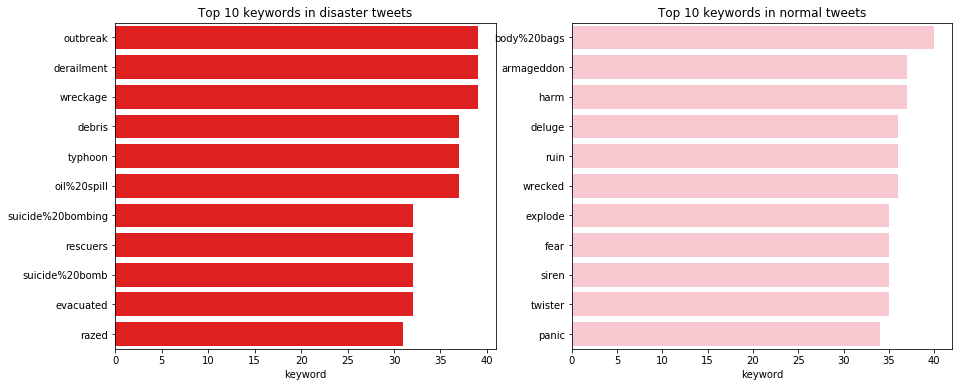

In [18]:
### Identifying top 10 keywords for disaster and non-disaster tweets ###
disaster = train.loc[train.target == 1]
top_d = disaster['keyword'].value_counts()
normal = train.loc[train.target == 0]
top_n = normal['keyword'].value_counts()
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.barplot(y = top_d.index[0:11], x = top_d.iloc[0:11], ax = ax1, orient ='h' , color = 'red')
ax1.set_title("Top 10 keywords in disaster tweets")
sns.barplot(y = top_n.index[0:11], x = top_n.iloc[0:11], ax = ax2, orient ='h', color = 'pink' )
ax2.set_title("Top 10 keywords in normal tweets")

## Number of characters in tweets

In [19]:
disaster.shape

(3271, 5)

Text(0.5, 1.0, 'Char in normal tweets')

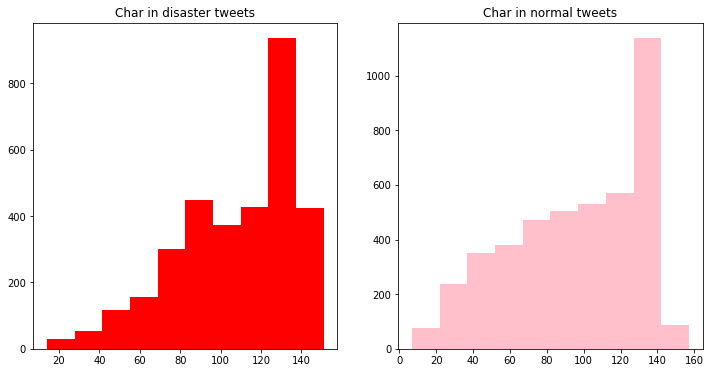

In [20]:
tweet_char_d = disaster.text.str.len()
tweet_char_d.sort_values(ascending = False)
tweet_char_n = normal.text.str.len()
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(tweet_char_d, color = 'red')
ax1.set_title("Char in disaster tweets")
ax2.hist(tweet_char_n, color = 'pink')
ax2.set_title("Char in normal tweets")

<a id="section-three"></a>
# 3. Preprocessing

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
type(string.punctuation)

str

In [23]:
def preprocess(element):
    
    ### convert all to lowercase ###
    element = element.lower()
    
    ### get rid of punctuation ###
    element = element.translate({ord(i): None for i in string.punctuation})
        
    
    ### get rid of weblinks ###
    element = re.sub('https?://\S+|www\.\S+', '', element)
    
    return element


train['text'] = train.text.map(preprocess)
test['text'] = test.text.map(preprocess)
train['text'].head(10)

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update  california hwy 20 closed in ...
6    flood disaster heavy rain causes flash floodin...
7    im on top of the hill and i can see a fire in ...
8    theres an emergency evacuation happening now i...
9     im afraid that the tornado is coming to our area
Name: text, dtype: object

<a id="section-four"></a>
# 4. Wordcloud

(-0.5, 599.5, 499.5, -0.5)

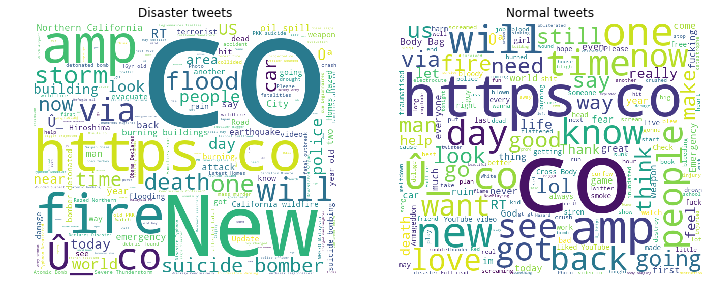

In [24]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
wc1 = WordCloud(background_color='white',width=  600,
                        height=500).generate(" ".join(disaster.text))
ax1.imshow(wc1)
ax1.set_title("Disaster tweets")
ax1.axis('off')
wc2 = WordCloud(background_color='white',width=600,
                        height=500).generate(" ".join(normal.text))
ax2.imshow(wc2)
ax2.set_title("Normal tweets")
ax2.axis('off')

## Tokenization

In [25]:

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].map(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].map(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [13000, people, receive, wildfires, evacuation...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [26]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Getting rid of stopwords

In [27]:
def stopwords_remove(text):
         words = [i for i in text if i not in stopwords.words('english')]
         return words
train.text = train.text.map(stopwords_remove)
test.text = test.text.map(stopwords_remove)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[13000, people, receive, wildfires, evacuation...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [28]:
### combining list of strings ###

def combine(text_list):
    joined_text = ' '.join(text_list)
    return joined_text

train['text'] = train['text'].map(combine)
test['text'] = test['text'].map(combine)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


<a id="section-five"></a>
# 5. Journey from tokens to vector

In [29]:
### Using CountVectorizer ###

countvec = CountVectorizer()
train_vec = countvec.fit_transform(train['text'])
test_vec = countvec.transform(test["text"])

In [30]:
### TFIDF ###

tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [31]:
test_tfidf

<3263x11714 sparse matrix of type '<class 'numpy.float64'>'
	with 29294 stored elements in Compressed Sparse Row format>

<a id="section-six"></a>
# 6. Text Classification models

## 1. Logistic Regression

In [32]:
lr = LogisticRegression(random_state = 42)
model = Pipeline([('classification', lr)])
param = {'classification__C': [0.001, 0.01, 0.1,1,  10, 100]}
grid_search_log = GridSearchCV(model, param, scoring ='f1',refit=True,  cv= 5)
grid_search_log.fit(train_vec,train['target'])
print(grid_search_log.best_estimator_)
log_best = grid_search_log.best_estimator_
resultsdf = pd.DataFrame(grid_search_log.cv_results_)
resultsdf

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(memory=None,
         steps=[('classification',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.084755,0.021919,0.003477,0.000195,0.001,{'classification__C': 0.001},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
1,0.088896,0.008553,0.003398,0.000062,0.01,{'classification__C': 0.01},0.337136,0.332075,0.286783,0.233161,0.467742,0.331379,0.077800,5
2,0.198818,0.055363,0.003612,0.000063,0.1,{'classification__C': 0.1},0.568750,0.490272,0.538462,0.519348,0.672630,0.557892,0.062798,3
3,0.371479,0.032768,0.003593,0.000051,1,{'classification__C': 1},0.598077,0.488616,0.565401,0.550615,0.672104,0.574963,0.060184,1
4,0.535764,0.015631,0.003552,0.000101,10,{'classification__C': 10},0.602612,0.482818,0.556465,0.491525,0.659761,0.558636,0.066958,2
5,0.583281,0.082621,0.003581,0.000116,100,{'classification__C': 100},0.600739,0.483404,0.554828,0.481132,0.664025,0.556826,0.070063,4


In [33]:
print("mean test score for Logistic Regression with Counts:", resultsdf.loc[resultsdf['rank_test_score']==1, ["mean_test_score"]])

mean test score for Logistic Regression with Counts:    mean_test_score
3         0.574963


In [34]:
lr = LogisticRegression(random_state = 42)
model = Pipeline([('classification', lr)])
param = {'classification__C': [0.001, 0.01, 0.1,1,  10, 100]}
grid_search_log = GridSearchCV(model, param, scoring ='f1',refit=True,  cv= 5)
grid_search_log.fit(train_tfidf,train['target'])
print(grid_search_log.best_estimator_)
log_best = grid_search_log.best_estimator_
resultsdf = pd.DataFrame(grid_search_log.cv_results_)
resultsdf
print("mean test score for Logistic Regression with TFIDF:", resultsdf.loc[resultsdf['rank_test_score']==1, ["mean_test_score"]])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(memory=None,
         steps=[('classification',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
mean test score for Logistic Regression with TFIDF:    mean_test_score
4         0.557423


Count vectorizer gives better performance than TFIDF with Logistic Regression

# 2. Naives Bayes Classifier

In [35]:
nb = MultinomialNB()
count_scores = cross_val_score(nb, train_vec, train["target"], cv=5, scoring="f1")
count_scores

array([0.63489362, 0.60614934, 0.68493151, 0.64177919, 0.72354949])

In [36]:
nb_tfidf = MultinomialNB()
tfidf_scores = cross_val_score(nb_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
tfidf_scores

array([0.56831683, 0.5704163 , 0.59735683, 0.59474672, 0.72354389])

In [37]:
nb_tfidf.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

<a id="section-seven"></a>
# 7. Submission

In [38]:


def save_submission_file(model):
    test_pred = model.predict(test_tfidf)
    dat ={'id':test['id'],  "target":test_pred}
    submission = pd.DataFrame(dat)
    csvfile = submission.to_csv("submission.csv", index=False)
    return csvfile
save_submission_file(nb_tfidf)

## Reference
https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro#-6.-Building-a-Text-Classification-model